# Toxicity Target Classification

In this notebook, we will train a baseline model to predict if a toxic comment is targeted or not.

We will use [simpletransformers](https://simpletransformers.ai/) that is a wrapper for many popular models available in [Hugging Face](https://huggingface.co/).

We will use a pre-trained model ([neuralmind/bert-base-portuguese-cased · Hugging Face](https://huggingface.co/neuralmind/bert-base-portuguese-cased)) that is trained on Portuguese.

## Imports

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent.parent))

In [2]:
from dotenv import load_dotenv

# Initialize the env vars
load_dotenv("../../.env")

True

In [3]:
import os
import shutil
import logging
import numpy as np
import pandas as pd
import mlflow
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from simpletransformers.classification import (
    ClassificationModel,
    ClassificationArgs
)

%matplotlib inline

logging.basicConfig(level=logging.INFO)

_logger = logging.getLogger("transformers")
_logger.setLevel(logging.WARNING)

mlflow.set_experiment("toxicity-type-detection")

mlflow.start_run(tags={"project": "olid-br"})

params = {
    "seed": 1993,
    "model_type": "bert",
    "model_name": "neuralmind/bert-base-portuguese-cased",
    "num_train_epochs": 6,
    "test_size": 0.3,
    "use_cuda": False
}

2022/06/18 11:59:49 INFO mlflow.tracking.fluent: Experiment with name 'toxicity-type-detection' does not exist. Creating a new experiment.


## Functions

In this section, we will define some helper functions.

In [4]:
def prep_data(X: List[str], Y: List[int], classes: Dict[Any, int]):
    """
    Prepare data (X, y) in a list.

    Args:
    - X: list of strings (texts)
    - y: List of ints (0 or 1)
    - classes: dictionary of classess ({class_id: class_name, ...})

    Returns:
        List of data.
    """

    def get_key_by_value(dictionary, value):
        "Get key by value in dictionary"
        return next(key for key, val in dictionary.items() if val == value)

    data = []
    for x, y in zip(X, Y):
        y = get_key_by_value(classes, y)
        data.append([x, y])
    return data

## Load the data

In this section, we will download the data and load it into a pandas dataframe.

In [5]:
# Download the data
if not os.path.exists("olidbr.csv"):
    print("Downloading data from Kaggle")
    kaggle = KaggleApi()
    kaggle.authenticate()
    kaggle.dataset_download_files(dataset="olidbr", unzip=True)

# Load data
df = pd.read_csv("olidbr.csv")

# Delete files
for file in ["olidbr.csv", "metadata.csv"]:
    os.remove(file)

# Log dataset version
olidbr = kaggle.dataset_view(dataset="olidbr")
mlflow.log_param("dataset_version", f"v{olidbr.currentVersionNumber}")

print(f"Shape: {df.shape}")
df.head()

Shape: (3702, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,77cfa0d543c6401e80d01de660dd179b,USER Adorei o comercial também Jesus. Só achei...,OFF,UNT,NaN,"[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 6...",False,False,True,False,False,False,True,False,False,False,False
1,d8951629c389468588f1aa7f6e1904f3,Cara isso foi muito babaca geral USER conhece ...,OFF,TIN,GRP,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,False,False,False,False,False
2,bfcb1a08908a45f99f24c293f9650031,Quem liga pra judeu kkkk,OFF,UNT,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,True,True,False,False,False,False,False,False,False,True
3,7163bc831fd54804898c6679f58f2838,"Se vc for porco, folgado e relaxado, você não ...",OFF,UNT,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,False,False,False,False,False
4,8e0aec8f8b2140db9295192b597d677c,"Rapaziada chata, né?! O cara trabalha c funk, ...",OFF,TIN,GRP,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,False,False,False,False,False


We need to filter out the comments that are not toxic.

In [6]:
df = df[df["is_offensive"] == "OFF"]
df.reset_index(drop=True, inplace=True)

print(f"Shape: {df.shape}")

Shape: (3251, 17)


## Explorative analysis

In the second cell, we load the data and perform an exploratory analysis.

In [7]:
df_eda = df[["text", "is_targeted"]].groupby("is_targeted").count()
df_eda.reset_index(inplace=True)
df_eda

,is_targeted,text
0,TIN,2015
1,UNT,1236


INFO:botocore.credentials:Found credentials in environment variables.


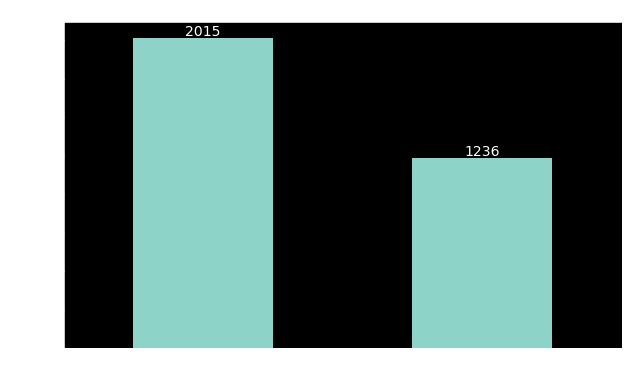

In [8]:
ax = df_eda.plot(x="is_targeted", y="text", kind="bar", legend=False, figsize=(10, 6),
                 xlabel="is_targeted", ylabel="count", fontsize=14,
                 rot=1, title="is_targeted distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

mlflow.log_figure(
    figure=ax.get_figure(),
    artifact_file="is_targeted_distribution.png")

In [9]:
classes = {
    0: "UNT",
    1: "TIN"
}

## Prepare the data

In this section, we will prepare the data in order to train the model.

The `simpletransformers` library expects the data in a specific format.

More information about the format can be found in the [Classification Data Formats - Simple Transformers](https://simpletransformers.ai/docs/classification-data-formats/#binary-classification)

In [10]:
df = df[["text", "is_targeted"]]

X = df["text"].values
y = df["is_targeted"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=params["test_size"],
                                                    random_state=params["seed"],
                                                    stratify=y)

train_data = prep_data(X_train, y_train, classes)
test_data = prep_data(X_test, y_test, classes)

df_train = pd.DataFrame(train_data)
df_train.columns = ["text", "labels"]

df_test = pd.DataFrame(test_data)
df_test.columns = ["text", "labels"]

mlflow.log_param("train_size", len(df_train))
mlflow.log_param("test_size", len(df_test))

print(f"train_data: {df_train.shape}")
print(f"test_data: {df_test.shape}")

train_data: (2275, 2)
test_data: (976, 2)


## Training the model

In this section, we will train a baseline model to predict if a toxic comment is targeted or not.

We will not perform hyperparameter tuning because it is a simple baseline model.

In [11]:
# Remove temporary folders
temp_folders = ["cache_dir", "outputs", "runs"]

for folder in temp_folders:
    if os.path.exists(folder):
        shutil.rmtree(folder, ignore_errors=True)

# Compute class weights
params["class_weights"] = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train)

# Optional model configuration
model_args = ClassificationArgs(
    num_train_epochs=params["num_train_epochs"])

mlflow.log_params(model_args.__dict__)

# Create a ClassificationModel
model = ClassificationModel(
    model_type=params["model_type"],
    model_name=params["model_name"],
    args=model_args,
    weight=list(params["class_weights"]),
    use_cuda=params["use_cuda"]
)

# Train the model
model.train_model(df_train)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

  0%|          | 0/2275 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_2_2
c:\ProgramData\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/285 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/285 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/285 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/285 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/285 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/285 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.


(1710, 0.28837426574727143)

## Evaluating the model

In this section, we will evaluate the model with the following metrics:

- **Accuracy**: the percentage of correct predictions;
- **Precision**: the percentage of predicted targeted comments that are actually targeted;
- **Recall**: the percentage of targeted comments that are actually predicted as targeted;
- **F1-Score**: the harmonic mean of precision and recall;

In [12]:
result, model_outputs, wrong_predictions = model.eval_model(df_test)

y_true = df_test["labels"].tolist()

y_pred, raw_outputs = model.predict(df_test["text"].tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/976 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2


Running Evaluation:   0%|          | 0/122 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.19304608824320157, 'tp': 456, 'tn': 160, 'fp': 211, 'fn': 149, 'auroc': 0.6285937047515093, 'auprc': 0.7078955505383471, 'eval_loss': 2.030188500190337}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

In [17]:
# Logging metrics in MLflow
metrics = classification_report(
    y_true, y_pred, digits=4,
    target_names=classes.values(), output_dict=True)

mlflow.log_metric("auroc", result["auroc"])
mlflow.log_metric("accuracy", metrics["accuracy"])
mlflow.log_metric("weighted_f1_score", metrics["weighted avg"]["f1-score"])
mlflow.log_metric("weighted_precision", metrics["weighted avg"]["precision"])
mlflow.log_metric("weighted_recall", metrics["weighted avg"]["recall"])

mlflow.log_metric("UNT_precision", metrics["UNT"]["precision"])
mlflow.log_metric("UNT_recall", metrics["UNT"]["recall"])
mlflow.log_metric("UNT_f1_score", metrics["UNT"]["f1-score"])
mlflow.log_metric("TIN_precision", metrics["TIN"]["precision"])
mlflow.log_metric("TIN_recall", metrics["TIN"]["recall"])
mlflow.log_metric("TIN_f1_score", metrics["TIN"]["f1-score"])

## Testing the model

In the last section, we will test the model with some comments from the test set.

In [18]:
df_pred = df_test.head(20)

predictions, raw_outputs = model.predict(df_pred["text"].tolist())

df_pred = df_pred.assign(predictions=predictions)

df_pred["labels"] = df_pred["labels"].map(classes)
df_pred["predictions"] = df_pred["predictions"].map(classes)

df_pred

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

,text,labels,predictions
0,Daqui a pouco você vai defender pedófilo. Pois...,TIN,TIN
1,USER pagou barato até pela imbecilidade que fa...,TIN,TIN
2,Os caras do canal USER grau devem estar rindo ...,TIN,TIN
3,o sea hoy me dio tanta rabia q literalmente se...,UNT,UNT
4,Como e que pode tantas pessoas sabendo como ta...,UNT,TIN
5,"USER VTNC seu psicopata, quer vacinar nossas c...",TIN,TIN
6,USER a HASHTAG USER se for pra falar merda nem...,TIN,TIN
7,Bem feito lógico nada justifica ter esfaqueado...,TIN,UNT
8,USER Retardado ladrão,TIN,TIN
9,USER Eu nem falei nada só falei do Cgi que ini...,UNT,TIN


In [19]:
mlflow.end_run()